## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle
from catboost import CatBoostClassifier, Pool
from scipy.sparse import hstack
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
import shap  
import gc
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
df_test = pd.read_csv('test.csv')

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.


## Рассмотрим датасет по ближе

In [4]:
df.head(5)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [5]:
df_test.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,N,0.0,N,N,85.0,...,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,N,4.0,Y,N,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,N,4.0,Y,N,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,N,0.0,N,N,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,956.0,...,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [8]:
df.describe()

,id,priority,class,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
count,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6000000.0,6.000000e+06,6.000000e+06,6.000000e+06,...,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06,6.000000e+06
mean,4.999167e+06,7.499824e+03,3.571923e-01,2.399936e+02,4.995037e+00,7.726733e-01,0.0,1.988388e+00,1.187661e+01,9.069800e-02,...,3.190689e+02,2.775095e+07,2.898887e+07,5.673982e+07,7.178686e+07,2.564167e-03,2.597737e-01,1.709710e-01,1.262833e-03,2.849667e-02
std,2.886491e+06,1.751917e+02,9.861573e-01,4.504002e+02,1.562659e-01,4.407572e-01,0.0,1.073716e-01,2.224794e+01,7.296577e+00,...,4.012494e+02,2.903655e+07,5.334262e+07,7.290388e+07,7.509270e+07,5.057264e-02,4.385104e-01,3.764837e-01,3.551392e-02,1.663869e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.500126e+06,7.503000e+03,0.000000e+00,5.200000e+01,5.000000e+00,1.000000e+00,0.0,2.000000e+00,0.000000e+00,0.000000e+00,...,3.100000e+01,1.113900e+06,1.064800e+04,1.673370e+06,1.040204e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.999348e+06,7.503000e+03,0.000000e+00,1.050000e+02,5.000000e+00,1.000000e+00,0.0,2.000000e+00,0.000000e+00,0.000000e+00,...,1.130000e+02,9.570832e+06,3.664710e+05,1.393496e+07,5.270807e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.498348e+06,7.506000e+03,0.000000e+00,2.640000e+02,5.000000e+00,1.000000e+00,0.0,2.000000e+00,2.295000e+01,0.000000e+00,...,9.140000e+02,5.610820e+07,8.331893e+07,1.321756e+08,1.368198e+08,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.999999e+06,7.506000e+03,5.000000e+00,1.580000e+05,9.000000e+00,5.000000e+00,0.0,2.000000e+00,8.305000e+02,1.024000e+03,...,1.142000e+03,1.416888e+08,4.156581e+08,4.897385e+08,5.002511e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
df_test.describe()

,id,priority,class,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4000000.0,4.000000e+06,4.000000e+06,4.000000e+06,...,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,5.001248e+06,7.499990e+03,3.570955e-01,2.399753e+02,4.995110e+00,7.731600e-01,0.0,1.988404e+00,1.187984e+01,9.705500e-02,...,4.556008e+02,3.189355e+02,2.773663e+07,2.897371e+07,5.671034e+07,7.177147e+07,2.582750e-03,2.597957e-01,1.707448e-01,1.236500e-03
std,2.887142e+06,1.716099e+02,9.855169e-01,3.967060e+02,1.554762e-01,4.403370e-01,0.0,1.073047e-01,2.224348e+01,7.640904e+00,...,2.115334e+03,4.011988e+02,2.903658e+07,5.333923e+07,7.290373e+07,7.509591e+07,5.075510e-02,4.385225e-01,3.762858e-01,3.514216e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.499771e+06,7.503000e+03,0.000000e+00,5.200000e+01,5.000000e+00,1.000000e+00,0.0,2.000000e+00,0.000000e+00,0.000000e+00,...,5.000000e+01,3.100000e+01,1.113748e+06,1.064800e+04,1.656011e+06,1.040204e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000941e+06,7.503000e+03,0.000000e+00,1.050000e+02,5.000000e+00,1.000000e+00,0.0,2.000000e+00,0.000000e+00,0.000000e+00,...,1.920000e+02,1.130000e+02,9.570832e+06,3.664710e+05,1.393496e+07,5.270807e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.502303e+06,7.506000e+03,0.000000e+00,2.650000e+02,5.000000e+00,1.000000e+00,0.0,2.000000e+00,2.291000e+01,0.000000e+00,...,4.190000e+02,9.140000e+02,5.610820e+07,8.331893e+07,1.321756e+08,1.368198e+08,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,9.999998e+06,7.506000e+03,5.000000e+00,1.580000e+05,8.000000e+00,5.000000e+00,0.0,2.000000e+00,8.305000e+02,1.024000e+03,...,1.597050e+05,1.142000e+03,1.416888e+08,4.156581e+08,4.897385e+08,5.002511e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
df.loc[0,:]

id                                    6818780
oper_type + oper_attr                 1043_-1
index_oper                           628629.0
type                                  Участок
priority                               7503.0
is_privatecategory                          N
class                                     0.0
is_in_yandex                                Y
is_return                                   N
weight                                   87.0
mailtype                                  5.0
mailctg                                   1.0
mailrank                                  0.0
directctg                                 2.0
transport_pay                             0.0
postmark                                  0.0
name_mfi                         Fishhook,USB
weight_mfi                               41.0
price_mfi                               150.0
dist_qty_oper_login_1                    42.0
total_qty_oper_login_1               720176.0
total_qty_oper_login_0            

<AxesSubplot:>

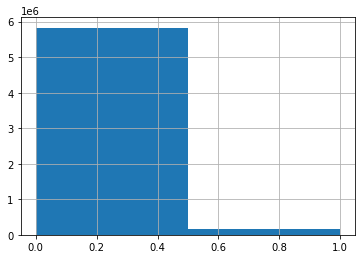

In [11]:
df["label"].hist(bins=2)

In [12]:
df['label'].value_counts()

0    5829020
1     170980
Name: label, dtype: int64

Дисбаланс классов присутствует.

### Анализ данных

#### oper_type + oper_attr

Тип и атрибут операции.

In [13]:
df["oper_type + oper_attr"].value_counts()

1020_-1    693154
1022_-1    656597
1019_-1    413710
8_0        402877
1_-1       359402
            ...  
2_2             1
12_6            1
2_11            1
2_10            1
1009_-1         1
Name: oper_type + oper_attr, Length: 109, dtype: int64

In [14]:
def scatter_analise(data, feature_x, feature_y):
    fig = plt.figure(figsize=(20,7))

    ax1 = fig.add_subplot(1,2,1)
    ax1 = sns.scatterplot(data=df[df['label'] == 0], x=feature_x, y=feature_y)
    ax1.set_title('label = 0')
    ax2 = fig.add_subplot(1,2,2)
    ax2 = sns.scatterplot(data=df[df['label'] == 1], x=feature_x, y=feature_y)
    ax2.set_title('label = 1')

In [15]:
def plt_analise(data, feature):
    fig = plt.figure(figsize=(20,7))

    ax1 = fig.add_subplot(1,2,1)
    ax1 = data[data['label'] == 0][feature].hist(bins=100)
    ax1.set_title('label = 0')
    ax2 = fig.add_subplot(1,2,2)
    ax2 = data[data['label'] == 1][feature].hist(bins=100)
    ax2.set_title('label = 1')

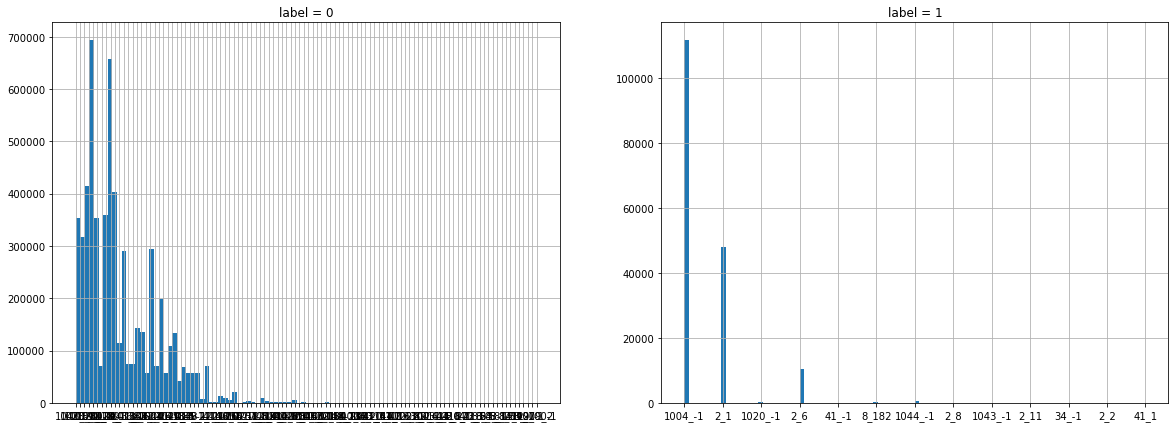

In [16]:
plt_analise(df, 'oper_type + oper_attr')

<AxesSubplot:xlabel='oper_type + oper_attr', ylabel='Count'>

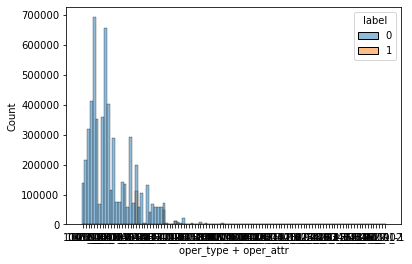

In [17]:
sns.histplot(data=df, x='oper_type + oper_attr', hue='label')

In [18]:
df_test["oper_type + oper_attr"].value_counts()

1020_-1    461403
1022_-1    437702
1019_-1    276312
8_0        268559
1_-1       240459
            ...  
12_21           1
14_19           1
1009_-1         1
6_5             1
3_10            1
Name: oper_type + oper_attr, Length: 102, dtype: int64

ValueError: Could not interpret value `oper_type` for parameter `x`

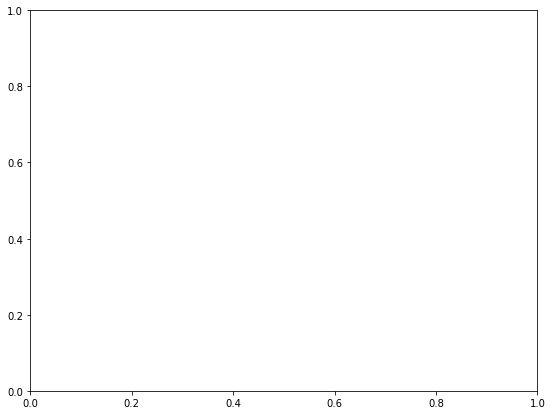

In [19]:
scatter_analise(df, 'oper_type', 'index_oper')

**Вывод:** Не совсем понятно почему две категории совместили в одну колонку. Думаю стоит разделить тип и атрибут операции.

#### index_oper

Индекс места операции

In [ ]:
df['index_oper'].unique()

In [ ]:
df_test['index_oper'].unique()

In [ ]:
df_test[df_test['index_oper'] == ' ']['id'].count()

In [ ]:
df[df['index_oper'] == ' ']['id'].count()

In [ ]:
plt_analise(df, 'index_oper')

**Вывод:** Необходимо преобразовать значения в числовой тип. Присутствуют пропуски.

#### type

Обозначение типа объекта почтовой связи

In [ ]:
df['type'].value_counts()

In [ ]:
df_test['type'].value_counts()

In [ ]:
plt_analise(df, 'type')

**Вывод:** Колонка содержит категориальные данные, требующие преобразования. Также есть пропуски, которые надо заполнить.

#### priority

Приоритет объекта

In [ ]:
df["priority"].value_counts()

In [ ]:
df_test["priority"].value_counts()

In [ ]:
plt_analise(df, 'priority')

**Вывод:** Колонка хоть и имеет числовой тип данных, но по смыслу это категориальные данные. Также есть пропуски, которые надо заполнить.

#### is_privatecategory

Тип отделения: закрытого или открытого типа.

In [ ]:
df["is_privatecategory"].value_counts()

In [ ]:
df_test["is_privatecategory"].value_counts()

In [ ]:
plt_analise(df, 'is_privatecategory')

**Вывод:** Колонка содержит категориальные данные, требующие преобразования. Также есть пропуски, которые надо заполнить.

#### class

Значение класса или категории объекта почтовой связи.

In [ ]:
df["class"].value_counts()

In [ ]:
sns.countplot(x = "class" , data  = df)

In [ ]:
df_test["class"].value_counts()

In [ ]:
plt_analise(df, 'class')

**Вывод:** Колонка содержит категориальные данные, требующие преобразования.

#### is_in_yandex

Адрес отделения связи отображается в Яндекс-картах или нет.

In [ ]:
df["is_in_yandex"].value_counts()

In [ ]:
df_test["is_in_yandex"].value_counts()

In [ ]:
plt_analise(df, 'is_in_yandex')

**Вывод:** Колонка содержит категориальные данные, требующие преобразования. Также есть пропуски, которые надо заполнить.

#### is_return

Отправление движется в направлении возврата отправителю или нет.

In [ ]:
df["is_return"].value_counts()

In [ ]:
df_test["is_return"].value_counts()

In [ ]:
plt_analise(df, 'is_return')

**Вывод:** Колонка содержит категориальные данные, требующие преобразования.

#### weight

Вес в граммах

In [ ]:
sns.countplot(x = "weight" , data  = df, hue='label');

In [ ]:
print(df['weight'].min())
print(df['weight'].max())
print(df['weight'].mean())
print(df['weight'].median())

In [ ]:
 df[df['weight'] < 100000]['weight']

In [ ]:
plt.boxplot( df[(df['weight'] < 50000) & (df['weight'] > 0)]['weight'])

In [ ]:
sns.countplot(x = "weight" , data  = df_test)

In [ ]:
print(df_test['weight'].min())
print(df_test['weight'].max())
print(df_test['weight'].mean())
print(df_test['weight'].median())

In [ ]:
plt.boxplot(df_test[(df_test['weight'] < 50000) & (df_test['weight'] > 0)]['weight'])

**Вывод:** Большая часть отправлений не содержит данных о весе, либо он очень мал. Максимальный вес составляет 158 кг., медиана - 105 грамм.

#### mailtype

Код вида отправления

In [ ]:
df['mailtype'].value_counts()

In [ ]:
df_test['mailtype'].value_counts()

In [ ]:
plt_analise(df[df['mailtype'] != 5], 'mailtype')

**Вывод:** Колонка содержит категориальные данные.

#### mailctg

Код категории почтового отправления

In [ ]:
df['mailctg'].value_counts()

In [20]:
df_test['mailctg'].value_counts()

 1.0    3127158
 0.0     836708
-1.0      35737
 3.0        383
 5.0         14
Name: mailctg, dtype: int64

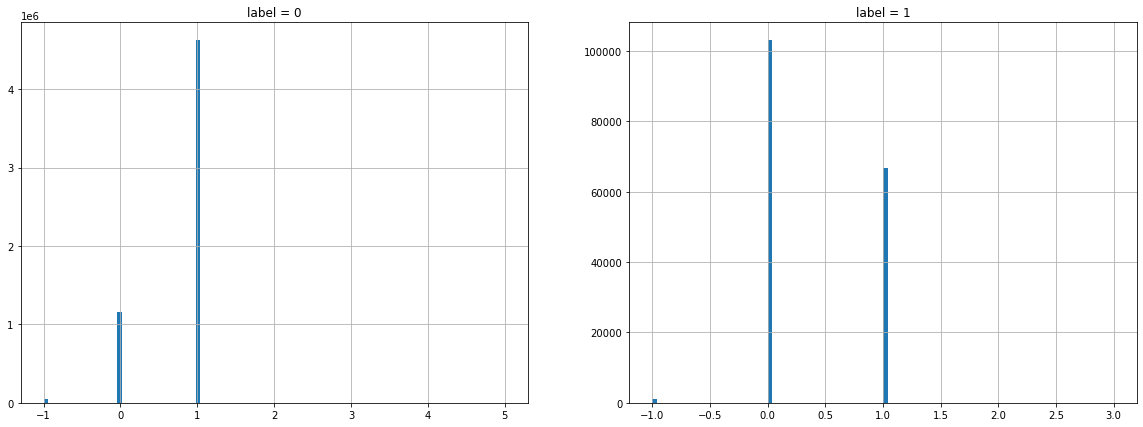

In [21]:
plt_analise(df, 'mailctg')

**Вывод:** Колонка содержит категориальные данные.

#### mailrank

Код разряда почтового отправления.

In [22]:
df['mailrank'].value_counts()

0.0    6000000
Name: mailrank, dtype: int64

In [23]:
df_test['mailrank'].value_counts()

0.0    4000000
Name: mailrank, dtype: int64

**Вывод:** Колонка константная. В модль для обучения её подавать не будем.

#### directctg

Код классификации отправления

In [24]:
df['directctg'].value_counts()

2.0    5930484
1.0      69361
0.0        155
Name: directctg, dtype: int64

In [25]:
df_test['directctg'].value_counts()

2.0    3953723
1.0      46171
0.0        106
Name: directctg, dtype: int64

**Вывод:** Колонка содержит категориальные данные, требующие преобразования. Также есть пропуски, которые надо заполнить.

#### transport_pay

Общая сумма платы за пересылку в условной валюте.

In [26]:
df['transport_pay'].describe()

count    6.000000e+06
mean     1.187661e+01
std      2.224794e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.295000e+01
max      8.305000e+02
Name: transport_pay, dtype: float64

<AxesSubplot:xlabel='transport_pay', ylabel='count'>

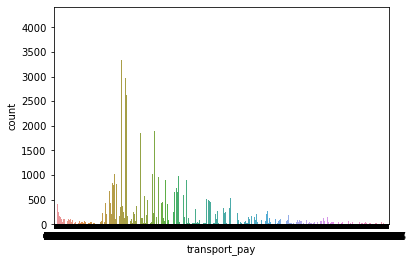

In [27]:
sns.countplot(x='transport_pay', data=df[df['transport_pay'] > 0])

{'whiskers': [<matplotlib.lines.Line2D at 0x18c50e2b460>,
 'caps': [<matplotlib.lines.Line2D at 0x18c80e74a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x18c50bbfdc0>],
 'medians': [<matplotlib.lines.Line2D at 0x18c80e74be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18c80e74f70>],
 'means': []}

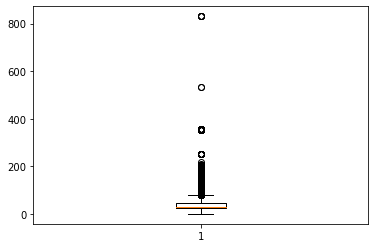

In [28]:
# plt.boxplot( df[(df['transport_pay'] < 50000) & (df['transport_pay'] > 0)]['transport_pay'])
plt.boxplot(df[df['transport_pay'] > 0]['transport_pay'])

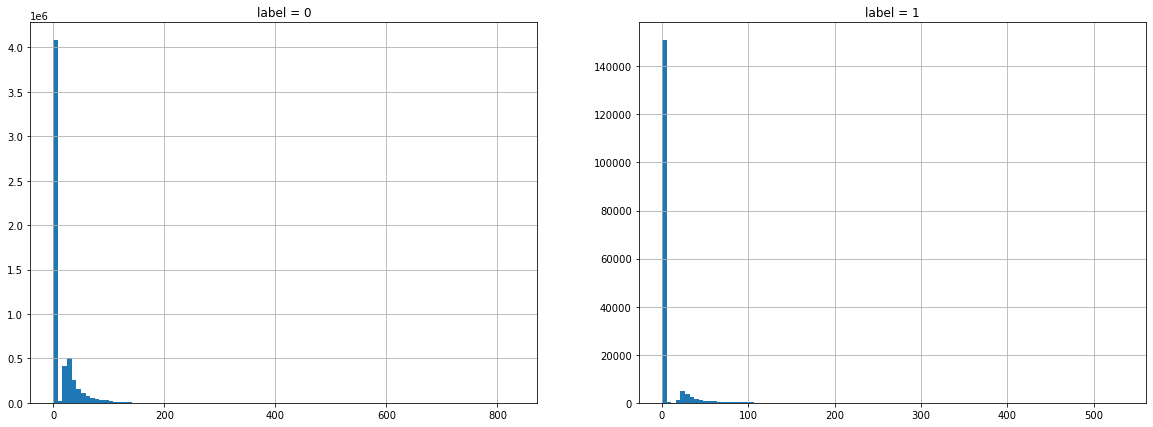

In [29]:
plt_analise(df, 'transport_pay')

In [30]:
df[df['label'] == 0]['transport_pay'].mean()

12.086243706490455

In [31]:
df_test['transport_pay'].describe()

count    4.000000e+06
mean     1.187984e+01
std      2.224348e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.291000e+01
max      8.305000e+02
Name: transport_pay, dtype: float64

In [32]:
df_test['transport_pay'].median()

0.0

{'whiskers': [<matplotlib.lines.Line2D at 0x18c91244a00>,
 'caps': [<matplotlib.lines.Line2D at 0x18c91239c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x18c912487c0>],
 'medians': [<matplotlib.lines.Line2D at 0x18c9122de80>],
 'fliers': [<matplotlib.lines.Line2D at 0x18c912287c0>],
 'means': []}

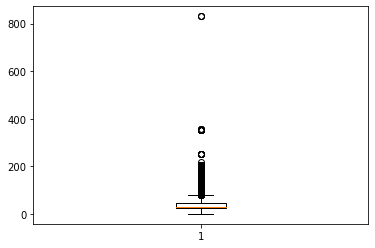

In [33]:
plt.boxplot(df_test[df_test['transport_pay'] > 0]['transport_pay'])

**Вывод:** Для большего числа отправлений цена не указана. Для отправлений с указанной ценой, она лежит в диапозоне 0 - 830

#### postmark 

Код отметки

In [34]:
df['postmark'].value_counts()

0.0       5998986
512.0         901
1024.0         79
8.0            23
256.0           7
1.0             4
Name: postmark, dtype: int64

In [35]:
df_test['postmark'].value_counts()

0.0       3999288
512.0         622
1024.0         67
8.0            15
256.0           4
1.0             4
Name: postmark, dtype: int64

**Вывод:** Для большего числа отправлений код отметки не указан или равен 0.

#### name_mfi

Наименование вложений (указано через запятую), указывается на бирке отправления.

In [36]:
df['name_mfi'].value_counts().head(50)

0                              815434
Mobile Phone Bags & Cases       48165
Screen Protectors               45032
phone case                      42696
Phone Case                      25031
Mobile Phone Cases & Covers     22516
cable                           17308
Stickers Decals                 15960
T-Shirts                        15887
screen protector                14994
Necklace                        14668
necklace                        14129
Earphones & Headphones          13648
Sunglasses                      13389
Phone Bumpers                   13122
shoes                           12773
Dresses                         12761
Car Stickers                    12600
Car decoration                  12024
Integrated Circuits             11930
BRA                             11352
Rings                            9124
Panties                          8894
hat                              8436
Socks                            8312
Phone case                       8243
dress       

In [37]:
df['name_mfi'].unique().shape

(212936,)

In [38]:
df_test['name_mfi'].value_counts().head(20)

0                              544856
Mobile Phone Bags & Cases       32122
Screen Protectors               30108
phone case                      28389
Phone Case                      16613
Mobile Phone Cases & Covers     15003
cable                           11701
T-Shirts                        10532
Stickers Decals                 10307
Necklace                        10029
screen protector                 9859
Earphones & Headphones           9195
necklace                         9102
Sunglasses                       9010
Phone Bumpers                    8944
Dresses                          8528
shoes                            8446
Car Stickers                     8322
Integrated Circuits              8273
Car decoration                   8085
Name: name_mfi, dtype: int64

In [39]:
df_test['name_mfi'].unique().shape

(205458,)

**Вывод:** Колонка содержит текстовые данные, в которых явно присутствуют дубликаты.

#### weight_mfi

Суммарная масса вложений

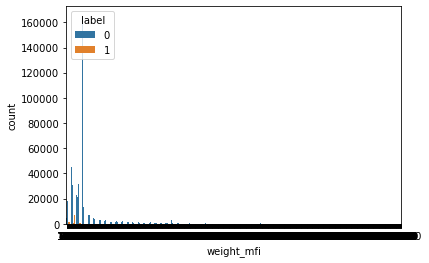

In [40]:
sns.countplot(x = "weight_mfi" , data  = df[df['weight_mfi'] > 0], hue='label');

In [41]:
print(df['weight_mfi'].min())
print(df['weight_mfi'].max())
print(df['weight_mfi'].mean())
print(df['weight_mfi'].median())

0.0
18000.0
123.65528183333333
60.0


{'whiskers': [<matplotlib.lines.Line2D at 0x18c91f7a850>,
 'caps': [<matplotlib.lines.Line2D at 0x18c91f7ae80>,
 'boxes': [<matplotlib.lines.Line2D at 0x18c91f7a5e0>],
 'medians': [<matplotlib.lines.Line2D at 0x18c80e5cb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x18c80e5c5e0>],
 'means': []}

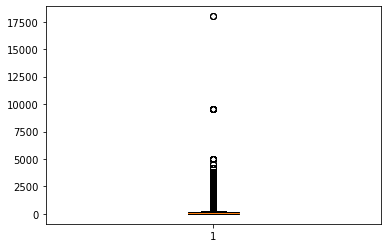

In [42]:
plt.boxplot( df[(df['weight_mfi'] < 50000) & (df['weight_mfi'] > 0)]['weight_mfi'])

In [43]:
df[df['label'] == 0]['weight'].max()

158000.0

In [44]:
df[df['label'] == 0]['weight_mfi'].median()

60.0

In [45]:
df[(df['label'] == 1)][['id',
                                     'weight',
                                     'weight_mfi',
                                     'label',
                                     'index_oper',
                                     'oper_type + oper_attr',
                                     'class',
                                     'type','name_mfi',
                                     'price_mfi',
                                     'transport_pay']].sort_values(by=['weight','name_mfi', 'price_mfi']).head(50)

,id,weight,weight_mfi,label,index_oper,oper_type + oper_attr,class,type,name_mfi,price_mfi,transport_pay
29959,3201286,0.0,0.0,1,456656.0,2_6,3.0,ГОПС,0,0.0,0.0
40115,443207,0.0,0.0,1,309183,2_6,2.0,ГОПС,0,0.0,0.0
100024,7076720,0.0,0.0,1,353860.0,2_6,2.0,ГОПС,0,0.0,0.0
107725,6173142,0.0,0.0,1,102976.0,1004_-1,0.0,ММПО,0,0.0,0.0
111844,8992559,0.0,0.0,1,442537.0,2_6,2.0,ГОПС,0,0.0,0.0
138574,4835340,0.0,0.0,1,396030,2_6,4.0,СОПС,0,0.0,0.0
177104,2550644,0.0,0.0,1,352101,2_6,4.0,СОПС,0,0.0,0.0
178392,2245059,0.0,0.0,1,184511,2_6,3.0,ГОПС,0,0.0,0.0
190489,7669318,0.0,0.0,1,403401,2_6,4.0,СОПС,0,0.0,0.0
203653,7588580,0.0,0.0,1,102976,1004_-1,0.0,ММПО,0,0.0,0.0


In [47]:
# df[(df['weight_mfi'] == 10)&
#    (df['weight'] == 101)][['id',
#                                      'weight',
#                                      'weight_mfi',
#                                      'label',
#                                      'index_oper',
#                                      'oper_type + oper_attr',
#                                      'class',
#                                      'type','name_mfi',
#                                      'price_mfi',
#                                      'transport_pay',
#                                       'number_oper']].sort_values(by=['weight','name_mfi', 'price_mfi']).head(50)

In [48]:
df[df['label'] == 1]['oper_type + oper_attr'].value_counts()

1004_-1    111489
2_1         47908
2_6         10352
1044_-1       506
1020_-1       345
8_182         296
41_-1          57
1043_-1        16
2_8             7
2_11            1
34_-1           1
2_2             1
41_1            1
Name: oper_type + oper_attr, dtype: int64

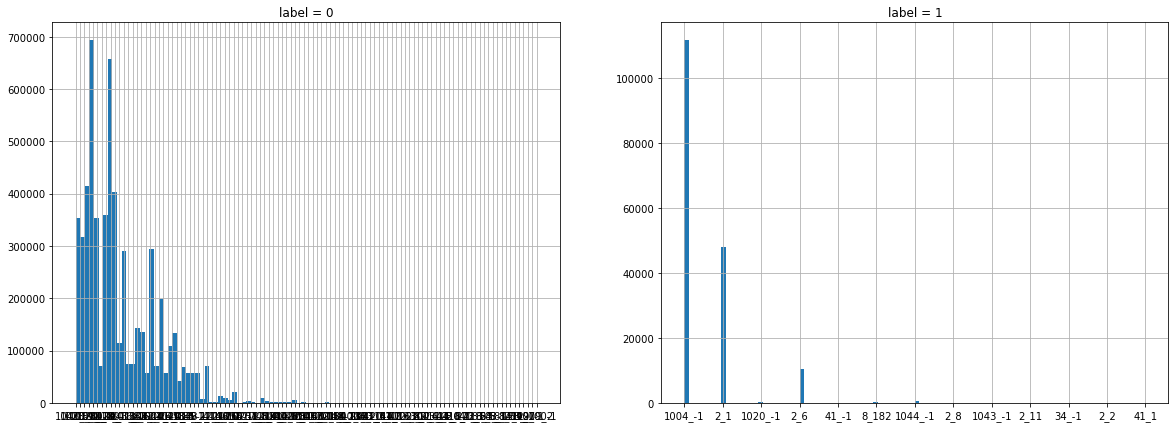

In [49]:
plt_analise(df, 'oper_type + oper_attr')

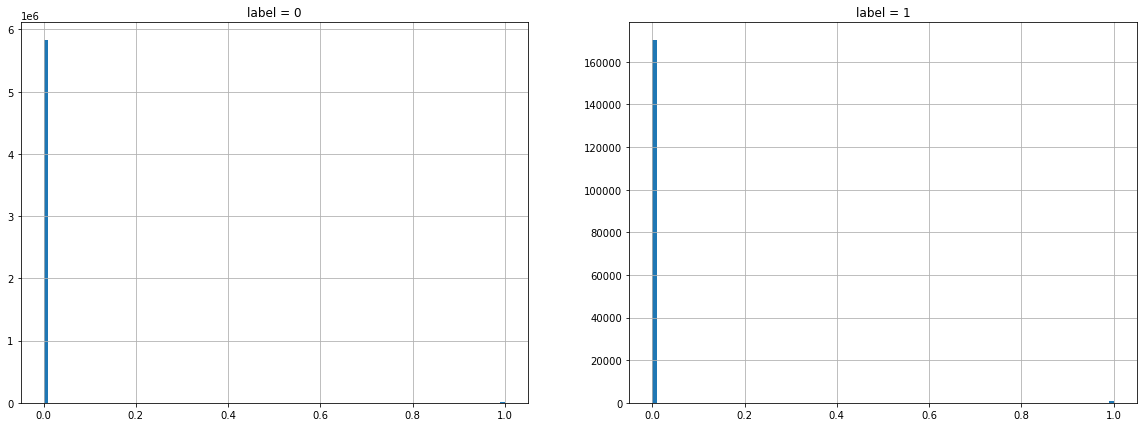

In [50]:
plt_analise(df, 'is_wrong_address')

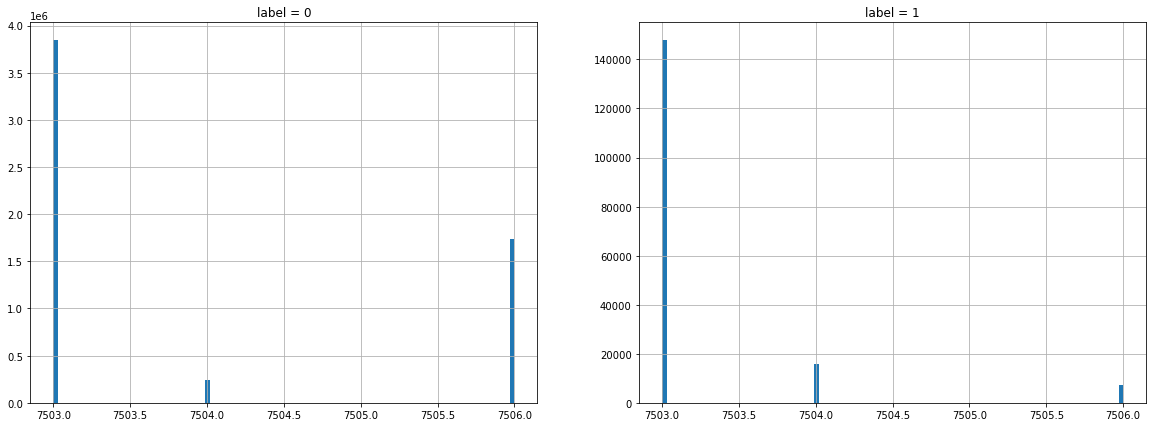

In [51]:
plt_analise(df[df['priority'] > 7000], 'priority')

In [52]:
df_all = pd.concat([df,df_test])

In [53]:
df_all

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0.0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0.0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0.0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0.0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,9030800,1017_1001,655003.0,ГОПС,7503.0,N,4.0,Y,N,53.0,...,3.0,4297.0,1803.0,6100.0,64613.0,0,0,0,0,NaN
3999996,6275048,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,286.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,1,0,0,NaN
3999997,4701757,1022_-1,102969.0,ТИ,7503.0,N,0.0,N,N,733.0,...,106.0,17348074.0,3469387.0,20817461.0,20821109.0,0,1,0,0,NaN
3999998,611153,39_-1,104006.0,Участок,7503.0,N,0.0,N,N,265.0,...,2.0,15.0,13673720.0,13673735.0,14041298.0,0,0,0,0,NaN


In [54]:
df[['weight',
     'weight_mfi',
     'label',
     'index_oper',
     'oper_type + oper_attr',
     'type','name_mfi',
     'price_mfi',
     'transport_pay']].groupby(['weight','weight_mfi'])['label','index_oper']

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [56]:
# df[df['zero'] == 0][['label']].value_counts()

In [58]:
# df['zero'] = df['index_oper'].apply(lambda x: 1 if str(x).partition('.')[2] else 0)

In [59]:
# df['zero'].value_counts()

<AxesSubplot:xlabel='weight', ylabel='weight_mfi'>

Creating legend with loc="best" can be slow with large amounts of data.


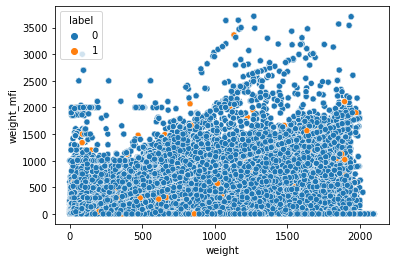

In [60]:
sns.scatterplot(data=df[(df['weight'] < 2100)&(df['weight_mfi'] < 4000)], x='weight', y='weight_mfi', hue='label')

In [61]:
df[df['weight'] > 17000][['weight','weight_mfi','label']]

,weight,weight_mfi,label
107914,158000.0,82.0,0
121103,158000.0,82.0,0
126749,158000.0,82.0,0
525060,158000.0,82.0,0
1018811,158000.0,82.0,0
1633487,158000.0,82.0,0
1748658,158000.0,82.0,0
1831571,158000.0,82.0,0
2084069,158000.0,82.0,0
2138559,158000.0,82.0,0


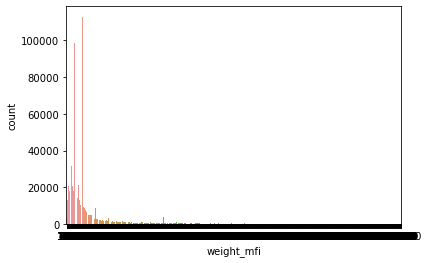

In [62]:
sns.countplot(x = "weight_mfi" , data  = df_test[df_test['weight_mfi'] > 0]);

In [63]:
print(df_test['weight_mfi'].min())
print(df_test['weight_mfi'].max())
print(df_test['weight_mfi'].mean())
print(df_test['weight_mfi'].median())

0.0
18000.0
123.717895
60.0


**Вывод:** Большая часть отправлений не содержит данных о весе соделжимого, либо он очень мал. Максимальный вес составляет 18 кг., медиана - 60 грамм.

#### price_mfi

Суммарная стоимость вложений в условной валюте.

In [64]:
df['price_mfi'].describe()

count    6.000000e+06
mean     4.560945e+02
std      2.103291e+03
min      0.000000e+00
25%      5.000000e+01
50%      1.920000e+02
75%      4.180000e+02
max      1.597050e+05
Name: price_mfi, dtype: float64

In [65]:
df_test['price_mfi'].describe()

count    4.000000e+06
mean     4.556008e+02
std      2.115334e+03
min      0.000000e+00
25%      5.000000e+01
50%      1.920000e+02
75%      4.190000e+02
max      1.597050e+05
Name: price_mfi, dtype: float64

In [66]:
df[df['price_mfi'] > 0]['price_mfi'].min()

1.0

**Вывод:** Для большего числа отправлений цена содержимого не указана. Для отправлений с указанной ценой вложения, она лежит в диапозоне 1 - 159705

#### dist_qty_oper_login_1

Количество уникальных имен операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора.

In [67]:
df['dist_qty_oper_login_1'].value_counts()

914.0     795886
1089.0    334082
184.0     329741
972.0     272750
153.0     239368
           ...  
75.0           3
135.0          1
222.0          1
89.0           1
95.0           1
Name: dist_qty_oper_login_1, Length: 165, dtype: int64

In [68]:
df_test['dist_qty_oper_login_1'].value_counts()

914.0     530203
1089.0    222425
184.0     219208
972.0     182242
153.0     158798
           ...  
284.0          3
349.0          2
95.0           2
110.0          2
75.0           1
Name: dist_qty_oper_login_1, Length: 164, dtype: int64

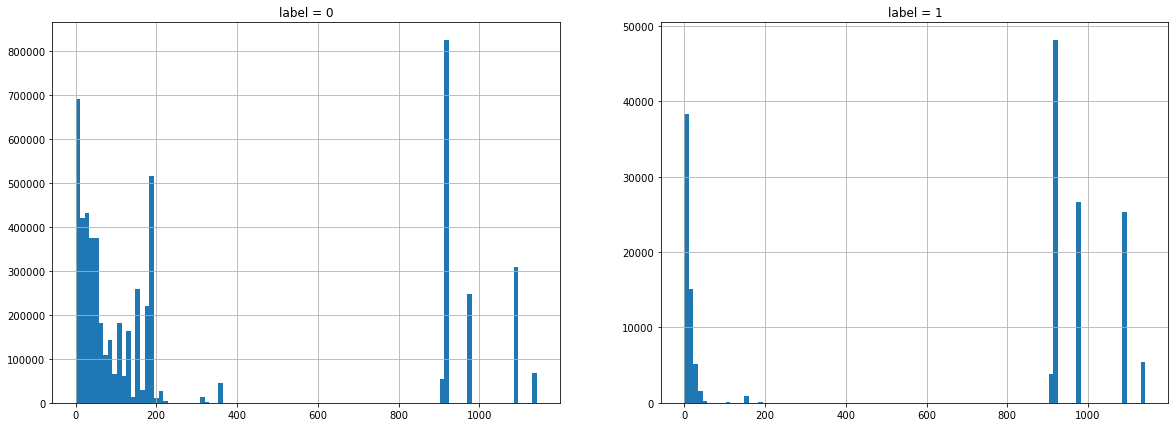

In [69]:
plt_analise(df, 'dist_qty_oper_login_1')

#### total_qty_oper_login_1 

Количество отправлений с уникальным именем операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора.

In [70]:
df['total_qty_oper_login_1'].value_counts()

48856658.0    795886
64270133.0    334082
67541214.0    329741
68766046.0    272750
76138189.0    159450
               ...  
38514.0            1
106624.0           1
5791.0             1
44447.0            1
9588.0             1
Name: total_qty_oper_login_1, Length: 18377, dtype: int64

In [71]:
df_test['total_qty_oper_login_1'].value_counts()

48856658.0    530203
64270133.0    222425
67541214.0    219208
68766046.0    182242
76138189.0    106650
               ...  
64052.0            1
15401.0            1
11125.0            1
1526786.0          1
18471.0            1
Name: total_qty_oper_login_1, Length: 18268, dtype: int64

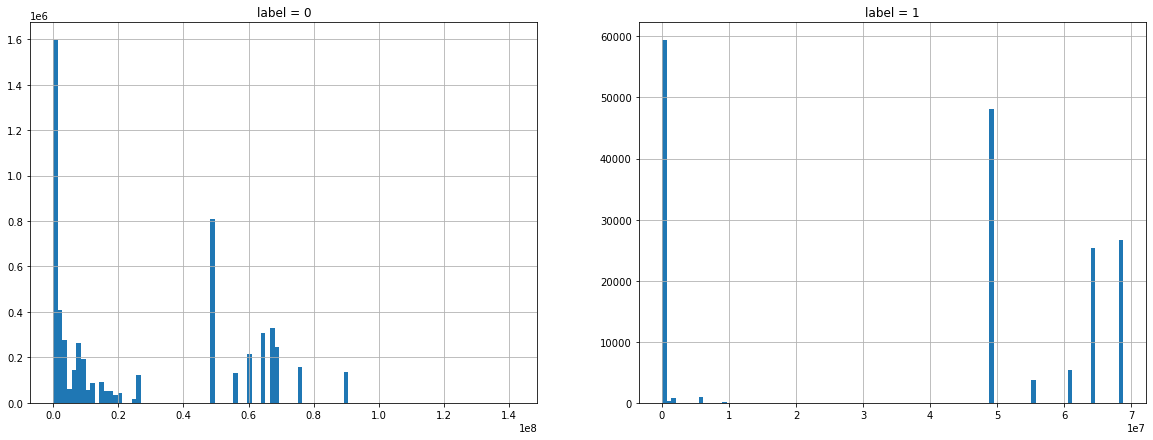

In [72]:
plt_analise(df, 'total_qty_oper_login_1')

In [73]:
df[df['label']==1]['total_qty_oper_login_1'].max()

68766046.0

In [74]:
df[df['label']==0]['total_qty_oper_login_1'].max()

141688843.0

In [75]:
df[df['label']==1]['dist_qty_oper_login_1'].max()

1142.0

<AxesSubplot:xlabel='dist_qty_oper_login_1', ylabel='total_qty_oper_login_1'>

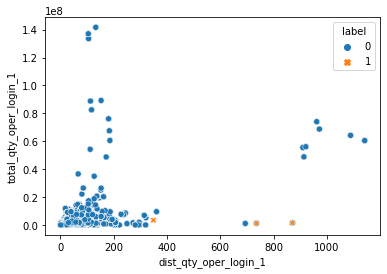

In [76]:
sns.scatterplot(data=df, x='dist_qty_oper_login_1', y='total_qty_oper_login_1', hue='label', style='label')

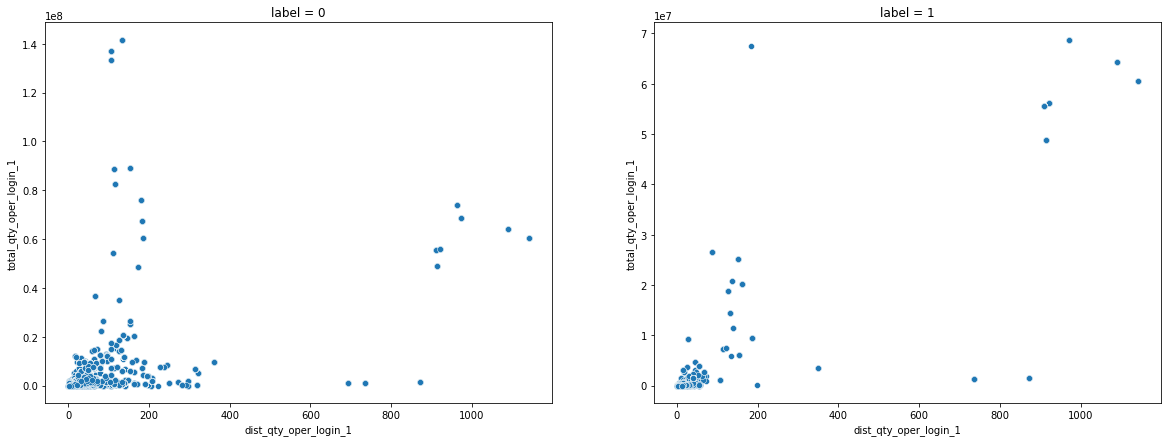

In [77]:
scatter_analise(df, 'dist_qty_oper_login_1', 'total_qty_oper_login_1')

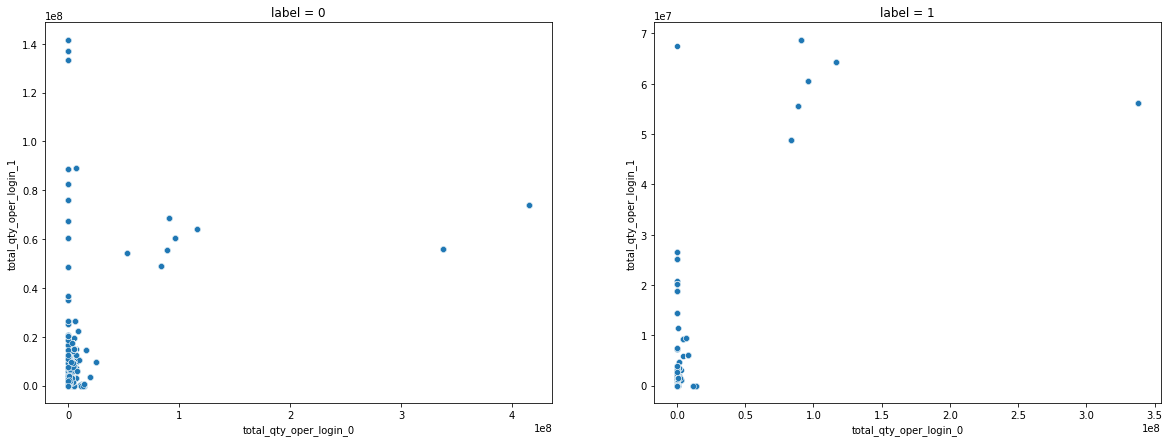

In [78]:
scatter_analise(df, 'total_qty_oper_login_0', 'total_qty_oper_login_1')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 30 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

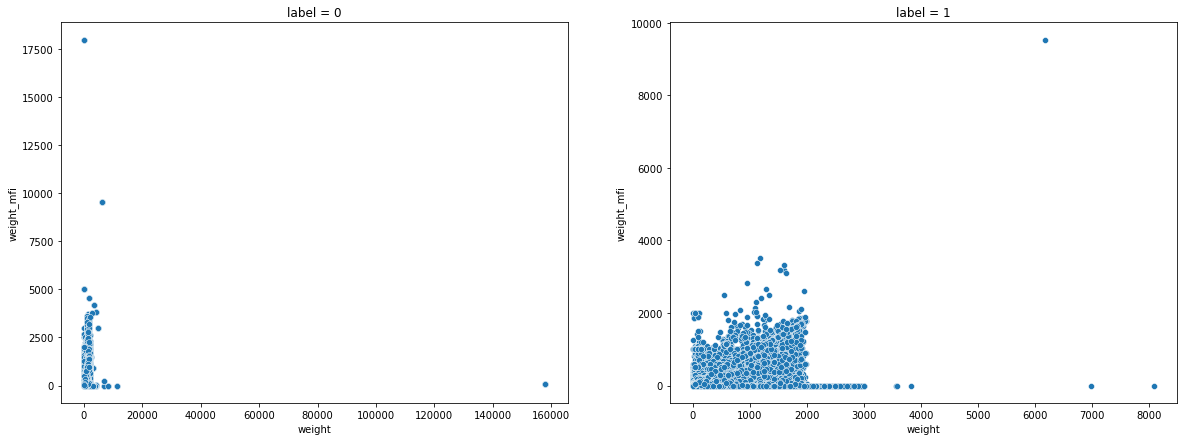

In [80]:
scatter_analise(df, 'weight', 'weight_mfi')

#### total_qty_oper_login_0 

Количество отправлений данного типа (mailtype), которые были обработаны неизвестным оператором на этом индексе.

In [81]:
df['total_qty_oper_login_0'].value_counts()

83318932.0     795886
116432632.0    334082
7870.0         329741
91123247.0     272750
8747.0         159450
                ...  
15936.0             1
19165.0             1
55367.0             1
10047.0             1
9755.0              1
Name: total_qty_oper_login_0, Length: 9351, dtype: int64

In [82]:
df_test['total_qty_oper_login_0'].value_counts()

83318932.0     530203
116432632.0    222425
7870.0         219208
91123247.0     182242
8747.0         106650
                ...  
21527.0             1
152240.0            1
7186.0              1
78644.0             1
6649.0              1
Name: total_qty_oper_login_0, Length: 9319, dtype: int64

In [83]:
df['total_qty_oper_login_0'].min()

0.0

#### total_qty_over_index_and_type

Общее количество отправлений данного типа (mailtype), прошедших обработку на этом индексе.

In [84]:
df['total_qty_over_index_and_type'].value_counts()

132175590.0    795886
180702765.0    334082
67549084.0     329741
159889293.0    272750
76146936.0     159450
                ...  
405817.0            1
37450.0             1
38834.0             1
8291.0              1
368597.0            1
Name: total_qty_over_index_and_type, Length: 20097, dtype: int64

In [85]:
df_test['total_qty_over_index_and_type'].value_counts()

132175590.0    530203
180702765.0    222425
67549084.0     219208
159889293.0    182242
76146936.0     106650
                ...  
4536.0              1
5265.0              1
2877.0              1
4289.0              1
10995.0             1
Name: total_qty_over_index_and_type, Length: 19977, dtype: int64

In [86]:
df['total_qty_over_index_and_type'].min()

0.0

#### total_qty_over_index

Общее количество отправлений, прошедших обработку на этом индексе.

In [87]:
df['total_qty_over_index'].value_counts()

136819803.0    795886
188407812.0    334082
72981134.0     329741
164927295.0    272795
84110459.0     159454
                ...  
1398.0              1
12251.0             1
4167.0              1
20898.0             1
36362.0             1
Name: total_qty_over_index, Length: 35188, dtype: int64

In [88]:
df_test['total_qty_over_index'].value_counts()

136819803.0    530203
188407812.0    222425
72981134.0     219208
164927295.0    182268
84110459.0     106656
                ...  
3885.0              1
2716.0              1
469.0               1
5696.0              1
6188.0              1
Name: total_qty_over_index, Length: 34027, dtype: int64

In [89]:
df['total_qty_over_index'].median()

52708071.0

#### is_wrong_sndr_name

Есть ли явные признаки, что имя отправителя введено некорректно?

In [90]:
df['is_wrong_sndr_name'].value_counts()

0    5984615
1      15385
Name: is_wrong_sndr_name, dtype: int64

In [91]:
df_test['is_wrong_sndr_name'].value_counts()

0    3989669
1      10331
Name: is_wrong_sndr_name, dtype: int64

#### is_wrong_rcpn_name

Есть ли явные признаки, что имя получателя введено некорректно?

In [92]:
df['is_wrong_rcpn_name'].value_counts()

0    4441358
1    1558642
Name: is_wrong_rcpn_name, dtype: int64

In [93]:
df_test['is_wrong_rcpn_name'].value_counts()

0    2960817
1    1039183
Name: is_wrong_rcpn_name, dtype: int64

#### is_wrong_phone_number

Есть ли явные признаки, что номер телефона получателя введен некорректно?

In [94]:
df['is_wrong_phone_number'].value_counts()

0    4974174
1    1025826
Name: is_wrong_phone_number, dtype: int64

In [95]:
df_test['is_wrong_phone_number'].value_counts()

0    3317021
1     682979
Name: is_wrong_phone_number, dtype: int64

#### is_wrong_address

Есть ли явные признаки, что адрес получателя введен некорректно?

In [96]:
df['is_wrong_address'].value_counts()

0    5992423
1       7577
Name: is_wrong_address, dtype: int64

In [97]:
df_test['is_wrong_address'].value_counts()

0    3995054
1       4946
Name: is_wrong_address, dtype: int64

Псотроим матрицу корреляции значений

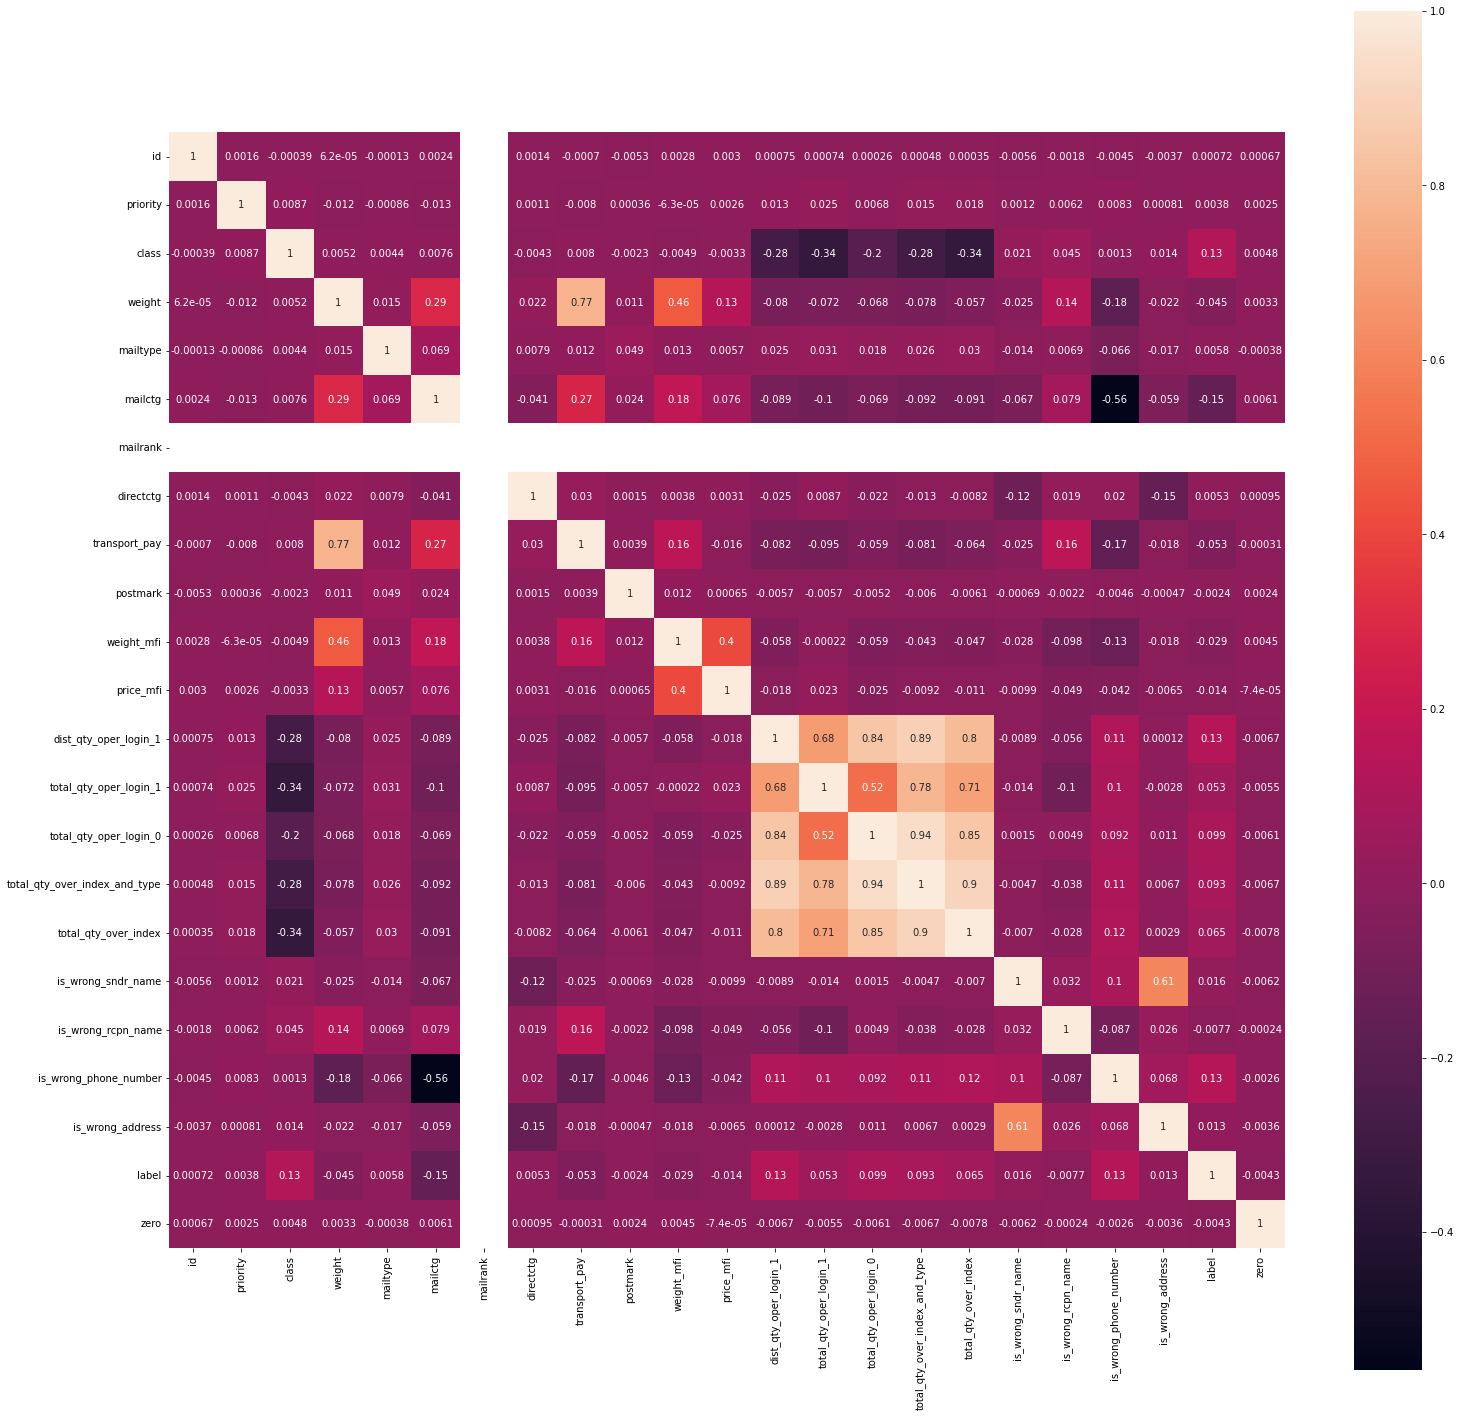

In [98]:
plt.rcParams['figure.figsize']=(25,25)


corr = df.iloc[:100000].corr()
g = sns.heatmap(corr, square = True, annot=True)

**Вывод**

1. Присутствует существенный дизбаланс классов. Необходимо это учитывать.
2. Пропуски:
    - `index_oper`
    - `type`
    - `priority`
    - `is_privatecategory`
    - `class` - '0' или пропуски - большая часть
    - `is_in_yandex`
    - `weight` - большая часть '0' либо есть отправления которые не взвешиваются(например простые письма)
    - `mailtype` - присутствует тип '0' - возможно это пропуск
    - `mailctg` - присутствует тип '0' - возможно это пропуск
    - `directctg` - присутствует тип '0' - возможно это пропуск
    - `transport_pay` - большая часть '0' - возможно это пропуск, но сделать мы врядли чтото сможем
    - `postmark` - большая часть '0' - возможно это пропуск, но сделать мы врядли чтото сможем. Возможно колонка не информативна окажется.
    - `name_mfi` - большая часть '0'
    - `weight_mfi` - большая часть '0'
    - `price_mfi` - большая часть '0'
    - `dist_qty_oper_login_1`
    - `total_qty_oper_login_1`
    - `total_qty_oper_login_0`
    - `total_qty_over_index_and_type`
    - `total_qty_over_index`
3. Колонка `mailrank` - пустая.
4. Преобразовать тип данных: `index_oper` - в integer
5. `mailctg` -1 ????
6. Вес содержимого больше веса посылки?
4. Идеи:
    - `oper_type + oper_attr` - разделить на `oper_type` и `oper_attr`
    - `is_in_yandex` и `is_return` преобразуем 'Y'=1, 'N'=0
    - Текстовые данные в колонке `name_mfi`, как минимум, привести к нижнему регистру.
    - На основе колонок `is_wrong_sndr_name`, `is_wrong_rcpn_name`, `is_wrong_phone_number`, `is_wrong_address` сделать интегральный признак.
    - Cоздать признак = `dist_qty_oper_login_1` / `total_qty_oper_login_0` (Отношение известных операторов к неизвестным)
    - Поделить индексы почтовых отправлений на 2-3 части (вытащим регион)
    - Cоздать признак = весу упаковки

## Подготовка данных

1. Преобразуем тип данных:
    - `index_oper`
2. Работа с пропусками:
 

In [99]:
df['number_oper'] = df.groupby(['weight','name_mfi', 'price_mfi','transport_pay','weight_mfi']).cumcount(ascending=False)
df_test['number_oper'] = df_test.groupby(['weight','name_mfi', 'price_mfi','transport_pay','weight_mfi']).cumcount(ascending=False)

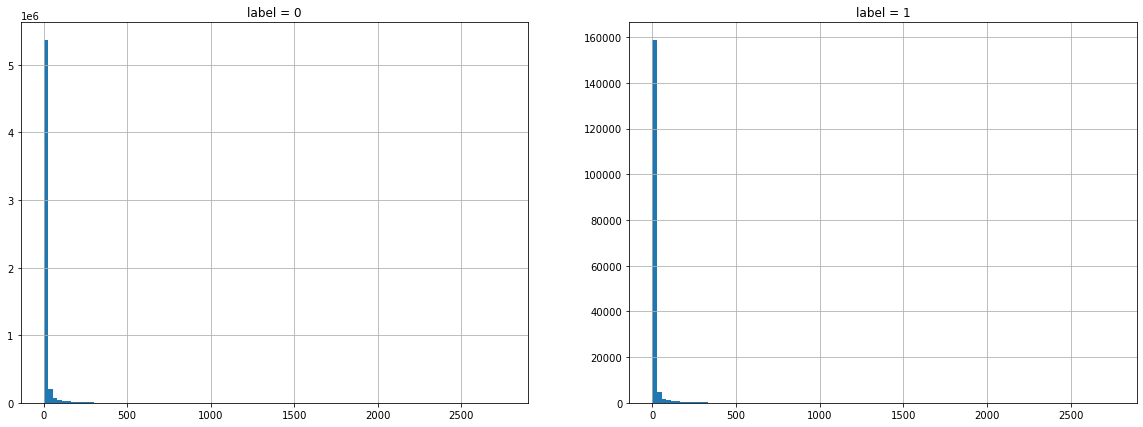

In [100]:
plt_analise(df, 'number_oper')

#### index_oper

Преобразуем тип данных

In [4]:
df.loc[df['index_oper'] == ' ', 'index_oper'] = '0'
df['index_oper'] = df['index_oper'].astype(float)
df['index_oper'] = df['index_oper'].astype(int)

In [5]:
df_test.loc[df_test['index_oper'] == ' ', 'index_oper'] = '0'
df_test['index_oper'] = df_test['index_oper'].astype(float)
df_test['index_oper'] = df_test['index_oper'].astype(int)

#### Заполнение пропусков

   - `index_oper` - замена самым частым
   - `type` - замена самым частым
   - `priority` - замена самым частым
   - `is_privatecategory` - замена самым частым
   - `class` - оставим как есть
   - `is_in_yandex` - замена самым частым
   - `weight` - оставим как есть (как вариант - замена медианой)
   - `mailtype` - замена самым частым
   - `mailctg` - оставим как есть
   - `directctg` - замена самым частым
   - `transport_pay` - оставим как есть (как вариант - замена медианой)
   - `postmark` - оставим как есть
   - `name_mfi` - оставим как есть
   - `weight_mfi` - оставим как есть (как вариант - замена медианой)
   - `price_mfi` - оставим как есть (как вариант - замена медианой)
   - `dist_qty_oper_login_1`
   - `total_qty_oper_login_1`
   - `total_qty_oper_login_0`
   - `total_qty_over_index_and_type`
   - `total_qty_over_index`

In [6]:
def fill_zero(data):
    data.loc[data['index_oper'] == 0, 'index_oper'] = data['index_oper'].value_counts().index[0]
    data.loc[data['type'] == '0', 'type'] = data['type'].value_counts().index[0]
    data.loc[data['priority'] == 0, 'priority'] = data['priority'].value_counts().index[0]
    data.loc[data['is_privatecategory'] == '0', 'is_privatecategory'] = data['is_privatecategory'].value_counts().index[0]
    data.loc[data['is_in_yandex'] == '0', 'is_in_yandex'] = data['is_in_yandex'].value_counts().index[0]
    data.loc[data['mailtype'] == 0, 'mailtype'] = data['mailtype'].value_counts().index[0]
    data.loc[data['directctg'] == 0, 'directctg'] = data['directctg'].value_counts().index[0]
    data.loc[data['dist_qty_oper_login_1'] == 0, 'dist_qty_oper_login_1'] = data['dist_qty_oper_login_1'].value_counts().index[0]
    data.loc[data['total_qty_oper_login_1'] == 0, 'total_qty_oper_login_1'] = data['total_qty_oper_login_1'].value_counts().index[0]
    data.loc[data['total_qty_oper_login_0'] == 0, 'total_qty_oper_login_0'] = data['total_qty_oper_login_0'].value_counts().index[0]
    data.loc[data['total_qty_over_index_and_type'] == 0, 'total_qty_over_index_and_type'] = data['total_qty_over_index_and_type'].value_counts().index[0]
    data.loc[data['total_qty_over_index'] == 0, 'total_qty_over_index'] = data['total_qty_over_index'].value_counts().index[0]
    # data.loc[data['weight'] == 0, 'weight'] = data['weight_mfi']
    # data.loc[data['weight_mfi'] > data['weight'], 'weight'] = data['weight_mfi']
    
    return data

In [7]:
# Средние значения для каждого названия вложения
data_median = pd.concat([df,df_test]).groupby('name_mfi')[['weight','weight_mfi', 'price_mfi', 'transport_pay']].mean()
data_median

,weight,weight_mfi,price_mfi,transport_pay
name_mfi,,,,
!NEW 8 Pack of 4.6 in,286.000000,257.0,948.0,0.00
# 8 Billiard Pool Ball,147.000000,152.0,16.0,0.00
$1 US gold card,670.000000,9.0,10.0,47.08
"$1 US gold card,wig,Tattoo stickers",113.000000,110.0,293.0,0.00
$1/20g-hub,13.538462,20.0,100.0,0.00
...,...,...,...,...
"黑色外壳T4,____T4",130.000000,256.0,1000.0,0.00
"黑色蚊帐,____",180.000000,356.0,1000.0,0.00
"鼠标,__",152.000000,300.0,1200.0,0.00


In [8]:
# Заполнение нулей средними значениями по названию содержимого
def fill_zero_maen(data):
    data.loc[data['transport_pay'] == 0, 'transport_pay'] = data[data['transport_pay'] == 0]['name_mfi'].apply(lambda x: data_median['transport_pay'][x])
    data.loc[data['weight'] == 0, 'weight'] = data[data['weight'] == 0]['name_mfi'].apply(lambda x: data_median['weight'][x])
    data.loc[data['weight_mfi'] == 0, 'weight_mfi'] = data[data['weight_mfi'] == 0]['name_mfi'].apply(lambda x: data_median['weight_mfi'][x])
    data.loc[data['price_mfi'] == 0, 'price_mfi'] = data[data['price_mfi'] == 0]['name_mfi'].apply(lambda x: data_median['price_mfi'][x])
    
    return data

In [9]:
df = fill_zero_maen(df)
df_test = fill_zero_maen(df_test)

In [10]:
df = fill_zero(df)
df_test = fill_zero(df_test)

#### Выбросы

- вес
- цена

In [108]:
# Обработка выбросов
df.loc[df['weight'] > 20000, 'weight'] = df[df['weight'] > 20000]['weight'] / 1000
df_test.loc[df_test['weight'] > 20000, 'weight'] = df_test[df_test['weight'] > 20000]['weight'] / 1000

#### Эти категории можно сделать ранговыми 

In [11]:
df["is_in_yandex"] = df["is_in_yandex"].apply(lambda x: 1 if x == 'Y' else 0)
df_test["is_in_yandex"] = df_test["is_in_yandex"].apply(lambda x: 1 if x == 'Y' else 0)

In [12]:
df["is_in_yandex"].value_counts()

0    3588626
1    2411374
Name: is_in_yandex, dtype: int64

In [13]:
df["is_return"] = df["is_return"].apply(lambda x: 1 if x == 'Y' else 0)
df_test["is_return"] = df_test["is_return"].apply(lambda x: 1 if x == 'Y' else 0)

In [14]:
df["is_return"].value_counts()

0    5993017
1       6983
Name: is_return, dtype: int64

### 'oper_type + oper_attr'

In [15]:
# Разделим колонку 'oper_type + oper_attr' на две
df[['oper_type', 'oper_attr']] = [_ for _ in df['oper_type + oper_attr'].apply(lambda x: x.split(sep='_'))]

df['oper_type'] = df['oper_type'].astype(int)
df['oper_attr'] = df['oper_attr'].astype(int)

In [16]:
# Разделим колонку 'oper_type + oper_attr' на две
df_test[['oper_type', 'oper_attr']] = [_ for _ in df_test['oper_type + oper_attr'].apply(lambda x: x.split(sep='_'))]

df_test['oper_type'] = df_test['oper_type'].astype(int)
df_test['oper_attr'] = df_test['oper_attr'].astype(int)

#### Текст

In [17]:
wnl = WordNetLemmatizer()
def mfi_normalizer(string):
    string = re.sub(r'\([^\)]+\)', '', string.lower())
    string = string.partition('(')[0]
    string = string.replace(',', ' ')
    string = re.sub(r'[^a-z ]', '', string)
    string = ' '.join([wnl.lemmatize(i) for i in string.split()])
    return string

# features = df['text'].apply(lambda x: ' '.join([wnl.lemmatize(re.sub(r'[^a-zA-Z]', ' ', i).lower()) for i in x.split()]))

In [18]:
mfi_normalizer(df.loc[40, 'name_mfi'])

'complete set of accessory heat shrink tube complete set of accessory heat shrink tube'

In [19]:
# df['name_mfi'] = df['name_mfi'].apply(mfi_normalizer)
df_test['name_mfi'] = df_test['name_mfi'].apply(mfi_normalizer)

In [118]:
# vect = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
# vect = CountVectorizer(ngram_range=(1,2), max_features=10000)

In [119]:
# X_train_mfi = vect.fit_transform(df['name_mfi'])

In [120]:
# X_test_mfi = vect.transform(df_test['name_mfi'])

In [121]:
# X_train_mfi

#### Генерация дополнительных фичей

In [41]:
# Генерация дополнительных признаков
def create_features(data):
    """ Принимаем датасет
        Возвращаем датасет с добавлением признаков
    """
    data[['index_oper_1','index_oper_2']] = [_ for _ in data['index_oper'].apply(lambda kod: [int(str(kod)[:3]), int(str(kod)[3:])])]
    # data['weight_wrong'] = data['weight'] < data['weight_mfi']
    data['is_wrong'] = data[[
                             # 'is_wrong_sndr_name', 
                             'is_wrong_rcpn_name', 
                             'is_wrong_phone_number', 
                             # 'is_wrong_address'
                           ]].apply(sum, axis=1)
    # data['login_01'] =  data['dist_qty_oper_login_1'] / data['total_qty_oper_login_0']
    data['login_01'] =  data['dist_qty_oper_login_1']*data['total_qty_oper_login_1']
    # data['wrong_return'] = data['is_wrong_sndr_name'] & data['is_return']
    data['wrong_adr'] = data['is_wrong_sndr_name'] & data['is_return']
    data['weight_sum'] = data['weight'] + data['weight_mfi']
    data['price_sum'] = data['transport_pay'] + data['price_mfi']
    data['price_per_gramm_mfi'] = data['price_mfi'] / (data['weight_mfi']+1)
    data['price_per_gramm'] = data['price_mfi'] / (data['weight']+1)
    data['price_per_transport'] = data['price_mfi'] / (data['transport_pay']+1)
    
    data['random'] = np.random.rand(data.shape[0])
    
    return data

In [123]:
def create_combinate_features(data):
    # data['index_oper + oper_type + oper_attr'] = data.apply(lambda x: str(x['index_oper']) +x['oper_type + oper_attr'], axis=1)
    # data['index_oper + type'] = data.apply(lambda x: str(x['index_oper']) +x['type'], axis=1)
    # data['index_oper + name_mfi'] = data.apply(lambda x: str(x['index_oper']) +x['name_mfi'], axis=1)
    # data['index_oper + weight'] = data.apply(lambda x: str(x['index_oper']) +str(x['weight']), axis=1)
    # data['index_oper + weight'] = data.apply(lambda x: str(x['index_oper']) +str(x['weight']), axis=1)
    # data['index_oper + weight_mfi'] = data.apply(lambda x: str(x['index_oper']) +str(x['weight_mfi']), axis=1)
    # data['index_oper + weight + weight_mfi'] = data.apply(lambda x: str(x['index_oper']) +str(x['weight']) +str(x['weight_mfi']), axis=1)
    # data['index_oper + weight + weight_mfi + name_mfi'] = data.apply(lambda x: str(x['index_oper']) +str(x['weight']) +str(x['weight_mfi']) + x['name_mfi'], axis=1)
    data['oper_type + oper_attr + type + mailctg'] = data.apply(lambda x: x['oper_type + oper_attr'] + x['type'] + str(x['mailctg']), axis=1)
    data['oper_type + oper_attr + type'] = data.apply(lambda x: x['oper_type + oper_attr'] + x['type'], axis=1)
    data['oper_type + oper_attr + mailctg'] = data.apply(lambda x: x['oper_type + oper_attr'] + str(x['mailctg']), axis=1)
    data['type + mailctg'] = data.apply(lambda x: x['type'] + str(x['mailctg']), axis=1)
    
                                     # 'index_oper',
                                     # 'oper_type + oper_attr',
                                     # 'class',
                                     # 'type','name_mfi',
                                     # 'price_mfi',
                                     # 'transport_pay'
    return data

In [124]:
# df = df.drop(columns=['random'])
# df_test = df_test.drop(columns=['random'])

In [125]:
%%time
df = create_combinate_features(df)

CPU times: total: 5min 7s
Wall time: 5min 11s


In [42]:
df = create_features(df)

In [57]:
df.head()


,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,index_oper_2,is_wrong,login_01,wrong_adr,weight_sum,price_sum,price_per_gramm_mfi,price_per_gramm,price_per_transport,random
0,6818780,26.0,628629,17.0,7503.0,0.0,0.0,1,0,87.0,...,629,0,3.024739e+07,0,128.0,150.00,3.571429,1.704545,150.000000,0.128044
1,9907176,20.0,102976,3.0,7503.0,0.0,0.0,0,0,107.0,...,976,0,4.465499e+10,0,175.0,400.00,5.797101,3.703704,400.000000,0.983111
2,3304275,15.0,620962,18.0,7503.0,0.0,0.0,1,0,50.0,...,962,1,2.012701e+08,0,106.0,218.00,3.824561,4.274510,218.000000,0.517710
3,9020937,16.0,344964,18.0,7503.0,0.0,0.0,1,0,416.0,...,964,0,1.133510e+08,0,449.0,135.34,2.941176,0.239808,2.751789,0.451247
4,3082311,17.0,629819,17.0,7503.0,0.0,0.0,1,0,795.0,...,819,0,5.070704e+06,0,1511.0,1052.52,1.394700,1.256281,18.684604,0.886897


In [128]:
%%time
df_test = create_combinate_features(df_test)

CPU times: total: 3min 26s
Wall time: 3min 30s


In [43]:
df_test = create_features(df_test)

In [130]:
# df.to_csv('train_preprpc.csv')
# df_test.to_csv('test_preprpc.csv')

In [46]:
# # Количество отправлений данного индекса
# index_range = df.groupby('index_oper')['id'].count()
# index_range.name = 'index_range'
# # students_on_group = students_on_group.apply(lambda x: x**2)
# # students_on_group = students_on_group.apply(lambda x: max(x, 3))

# # Добавляем в датасеты
# df = df.merge(index_range, on='index_oper', how='left')
# df_test = df_test.merge(index_range, on='index_oper', how='left')
# df_test = df_test.fillna(1)

In [132]:
# # Доля потерь в индексах
# index_score = df.groupby('index_oper')['label'].mean()
# index_score.name = 'index_score'

# # Добавляем в датасеты
# df = df.merge(index_score, on='index_oper', how='left')
# df_test = df_test.merge(index_score, on='index_oper', how='left')
# df_test = df_test.fillna(0)

In [133]:
# # Доля потерь в типах операций
# oper_type_score = df.groupby('oper_type')['label'].mean()
# oper_type_score.name = 'oper_type_score'

# # Добавляем в датасеты
# df = df.merge(oper_type_score, on='oper_type', how='left')
# df_test = df_test.merge(oper_type_score, on='oper_type', how='left')
# df_test = df_test.fillna(0)

In [134]:
# # Доля потерь в типах отделений
# type_score = df.groupby('type')['label'].mean()
# type_score.name = 'type_score'

# # Добавляем в датасеты
# df = df.merge(type_score, on='type', how='left')
# df_test = df_test.merge(type_score, on='type', how='left')
# df_test = df_test.fillna(0)

In [135]:
# # Доля потерь в типах отделений
# mailctg_score = df.groupby('mailctg')['label'].mean()
# mailctg_score.name = 'mailctg_score'

# # Добавляем в датасеты
# df = df.merge(mailctg_score, on='mailctg', how='left')
# df_test = df_test.merge(mailctg_score, on='mailctg', how='left')
# df_test = df_test.fillna(0)


In [136]:
# df['oper_index_score'] = df.apply(lambda x: x['index_score'] if x['oper_type_score'] > 0.4 else 0 , axis=1)


In [137]:
# df_test['oper_index_score'] = df_test.apply(lambda x: x['index_score'] if x['oper_type_score'] > 0.4 else 0 , axis=1)

In [44]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,index_oper_2,is_wrong,login_01,wrong_adr,weight_sum,price_sum,price_per_gramm_mfi,price_per_gramm,price_per_transport,random
0,6818780,26.0,628629,17.0,7503.0,0.0,0.0,1,0,87.0,...,629,0,3.024739e+07,0,128.0,150.00,3.571429,1.704545,150.000000,0.336526
1,9907176,20.0,102976,3.0,7503.0,0.0,0.0,0,0,107.0,...,976,0,4.465499e+10,0,175.0,400.00,5.797101,3.703704,400.000000,0.215343
2,3304275,15.0,620962,18.0,7503.0,0.0,0.0,1,0,50.0,...,962,1,2.012701e+08,0,106.0,218.00,3.824561,4.274510,218.000000,0.979149
3,9020937,16.0,344964,18.0,7503.0,0.0,0.0,1,0,416.0,...,964,0,1.133510e+08,0,449.0,135.34,2.941176,0.239808,2.751789,0.987948
4,3082311,17.0,629819,17.0,7503.0,0.0,0.0,1,0,795.0,...,819,0,5.070704e+06,0,1511.0,1052.52,1.394700,1.256281,18.684604,0.112539


In [139]:
# df[(df['oper_type_score'] > 0.4)&(df['index_score'] > 0.5)]['label'].hist()

In [140]:
# sns.scatterplot(data=df, x='index_score', y='oper_type_score', hue='label')
# # sns.scatterplot(data=df, x='index_score', y='total_qty_over_index', hue='label')

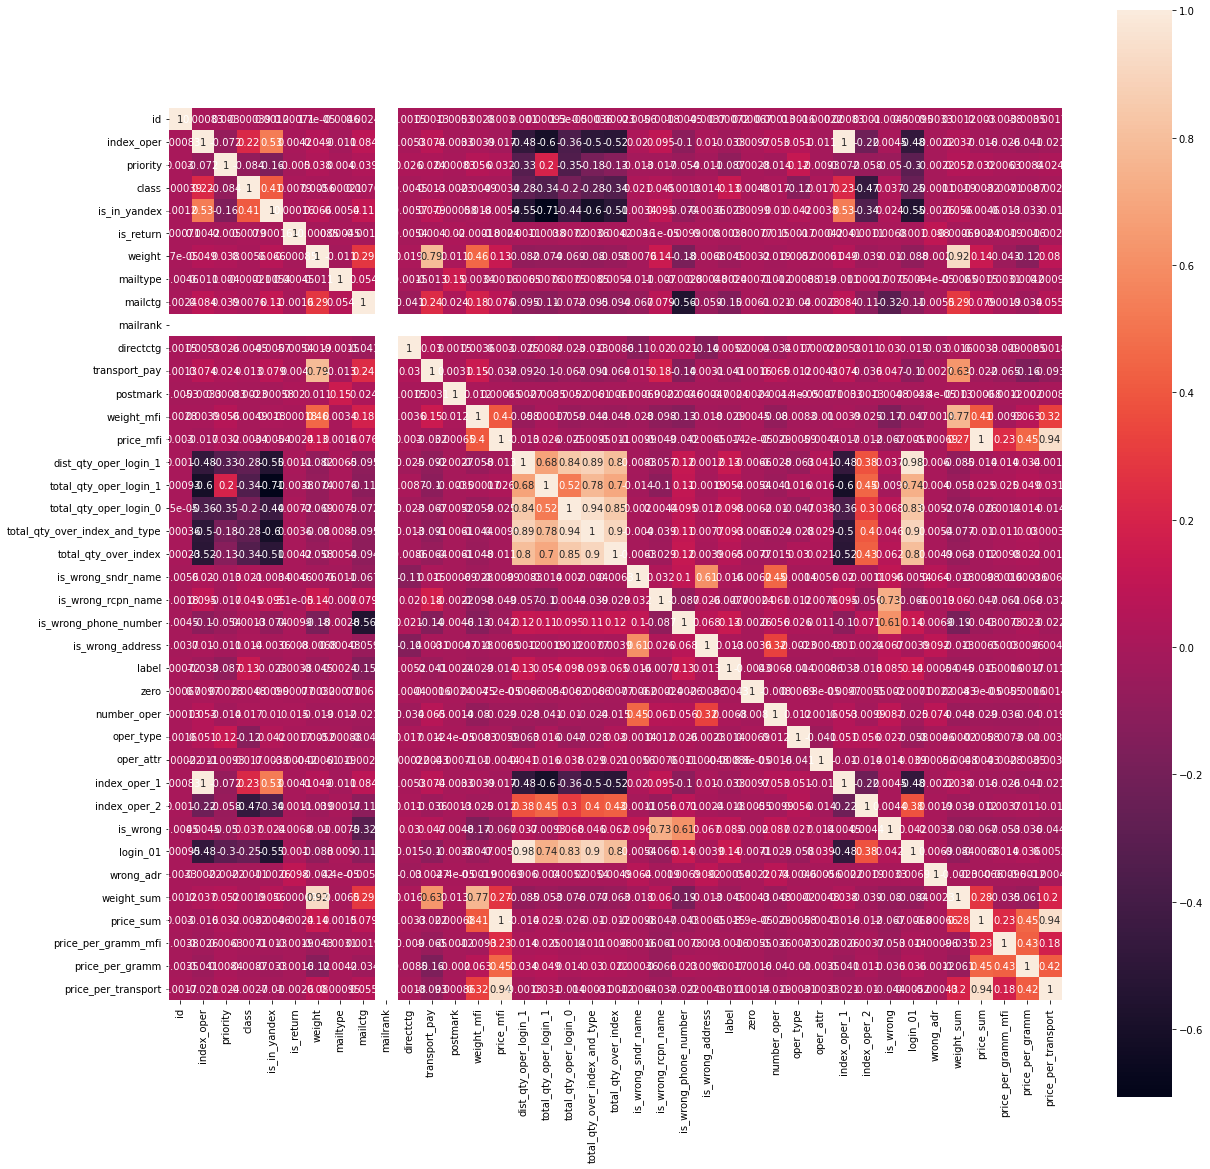

In [141]:
# sns.pairplot(df.iloc[:100000], hue='label');
plt.rcParams['figure.figsize']=(20,20)


corr = df.iloc[:100000].corr()
g = sns.heatmap(corr, square = True, annot=True)

In [142]:
# drop_obj = ['oper_type + oper_attr',
#             'type',
#             'is_privatecategory',
#             'name_mfi',
#             'weight_wrong'
# ]
# sns.pairplot(df.iloc[:10000].drop(columns=drop_obj), hue='label');


## Выделим выборки

In [14]:
df = df.fillna(0)

In [2]:
df = pd.read_csv("train_preprpc.csv")
# df = df.drop(['Unnamed: 0','zero'], 1)

In [3]:
df_test = pd.read_csv('test_preprpc.csv')
# df_test = df_test.drop('Unnamed: 0', 1)

In [20]:
categorical_columns = [_ for _ in df.select_dtypes(include=['object']).columns.values]
# categorical_columns.remove("name_mfi")
categorical_columns

['oper_type + oper_attr', 'type', 'is_privatecategory', 'name_mfi']

In [21]:
# df[categorical_columns] = df[categorical_columns].astype('str')
# df_test[categorical_columns] = df_test[categorical_columns].astype('str')

In [22]:
# Преобразование категориальных признаков
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 9999999)
df[categorical_columns] = encoder.fit_transform(df[categorical_columns])
df_test[categorical_columns] = encoder.transform(df_test[categorical_columns])


In [23]:
bad_features = [
                # 'mailrank', 
                # 'postmark',
                # 'is_privatecategory',
                # 'mailtype',
                # 'is_return',
                # 'is_wrong_address',
                # 'is_wrong_sndr_name',
                # 'oper_type',
                # 'oper_attr',
                # 'name_mfi',
                # 'is_wrong_rcpn_name', 
                # 'is_wrong_phone_number',
                # 'login_01'
               ]

In [45]:
# X = df.drop(['id', 'label', 'mailrank', 'name_mfi'], axis = 1)
# X_f = df.drop(bad_features+no_efect_features+["id", "label"], axis = 1)
X_f = df.drop(["id", "label"], axis = 1)

y = df["label"]

In [46]:
# X_train_mfi.shape

In [47]:
# Добавление векторизованного текста
# X = hstack((X_f, X_train_mfi)).tocsr()
X = X_f

In [48]:
gc.collect()

0

In [10]:
def upsample(features, target, repeat, features_noise=[]):
    """ Функция принемает признаки, целевой признак, количество повторений единиц.
        Возвращает увеличенную выборку"""
    # Деление признаков на 0 и 1
    features_zeros = features[target == 0]
    features_ones  = features[target == 1]
    target_zeros   = target[target == 0]
    target_ones    = target[target == 1]
    # Формирование фичей и таргета с увеличением единиц
    # features_ones = pd.concat([features_ones] * repeat)
    # print(features_ones.shape)
    # features_ones[features_noise] = features_ones[features_noise] * np.random.normal(1, 0.05, features_ones[features_noise].shape)
        
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    # features_upsampled = pd.concat([features_zeros] + [features_ones])
    
    target_upsampled   = pd.concat([target_zeros] + [target_ones] * repeat)
    # Перемешивание
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Создание увеличенной тренировочной выборки
f_noise = ['weight',
           'transport_pay',
           'weight_mfi',
           'price_mfi',
           # 'dist_qty_oper_login_1',
           # 'total_qty_oper_login_1',
           # 'total_qty_oper_login_0',
           # 'total_qty_over_index_and_type',
           # 'total_qty_over_index'
]
features_upsampled, target_upsampled = upsample(X, y, 10, f_noise)

In [11]:
features_upsampled.shape

(7538820, 46)

In [12]:
X = features_upsampled
y= target_upsampled

In [49]:
X.shape

(6000000, 40)

In [16]:
# X.head(50) #$.sort_values(by=['weight'])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
X_train.shape

NameError: name 'X_train' is not defined

In [17]:
# df_test = df_test.fillna(0)

In [18]:
# df_test[categorical_columns] = encoder.transform(df_test[categorical_columns])

In [50]:
# X_test_f = df_test.drop(["id", "name_mfi"], axis = 1)
# X_test_f = df_test.drop(bad_features+no_efect_features+["id"], axis = 1)
X_test_f = df_test.drop(["id"], axis = 1)

In [51]:
# Добавление векторизованного текста
# X_test  = hstack((X_test_f,  X_test_mfi )).tocsr()
X_test = X_test_f

In [52]:
X_test.shape

(4000000, 40)

In [53]:
X.head()

,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,index_oper_2,is_wrong,login_01,wrong_adr,weight_sum,price_sum,price_per_gramm_mfi,price_per_gramm,price_per_transport,random
0,26.0,628629,17.0,7503.0,0.0,0.0,1,0,87.0,5.0,...,629,0,3.024739e+07,0,128.0,150.00,3.571429,1.704545,150.000000,0.336526
1,20.0,102976,3.0,7503.0,0.0,0.0,0,0,107.0,5.0,...,976,0,4.465499e+10,0,175.0,400.00,5.797101,3.703704,400.000000,0.215343
2,15.0,620962,18.0,7503.0,0.0,0.0,1,0,50.0,5.0,...,962,1,2.012701e+08,0,106.0,218.00,3.824561,4.274510,218.000000,0.979149
3,16.0,344964,18.0,7503.0,0.0,0.0,1,0,416.0,5.0,...,964,0,1.133510e+08,0,449.0,135.34,2.941176,0.239808,2.751789,0.987948
4,17.0,629819,17.0,7503.0,0.0,0.0,1,0,795.0,5.0,...,819,0,5.070704e+06,0,1511.0,1052.52,1.394700,1.256281,18.684604,0.112539


In [54]:
X_test.head()

,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,index_oper_2,is_wrong,login_01,wrong_adr,weight_sum,price_sum,price_per_gramm_mfi,price_per_gramm,price_per_transport,random
0,95.0,102976,3.0,7503.0,0.0,0.0,0,0,85.0,5.0,...,976,0,6.684060e+10,0,158.0,489.00,6.608108,5.686047,489.000000,0.674664
1,99.0,238753,2.0,7503.0,0.0,4.0,1,0,21.0,5.0,...,753,2,5.790000e+03,0,40.0,186.00,9.300000,8.454545,186.000000,0.386387
2,17.0,618254,2.0,7503.0,0.0,4.0,1,0,388.0,5.0,...,254,0,8.253000e+03,0,736.0,534.01,1.432665,1.285347,14.281634,0.726127
3,11.0,102968,14.0,7503.0,0.0,0.0,0,0,1203.0,5.0,...,968,1,6.471930e+08,0,1203.0,83.72,0.000000,0.000000,0.000000,0.024325
4,15.0,102971,18.0,7506.0,0.0,0.0,0,0,956.0,5.0,...,971,1,1.378101e+10,0,1902.0,1281.95,1.337909,1.323929,79.435737,0.540467


In [24]:
# X = X.drop(no_efect_features, axis=1)
# X_test = X_test.drop(no_efect_features, axis=1)

In [52]:
# df.to_csv('train_preprpc.csv', index=False)
# df_test.to_csv('test_preprpc.csv', index=False)

## Обучение модели

In [ ]:
def score_rar(y_val, pred):
    score_recall = recall_score(y_val, pred, average = "macro")
    score_ar = roc_auc_score(y_val, pred)

    print("Recall =", score_recall)
    print("roc_auc =", score_ar)
    print("Recall+roc_auc =", score_recall * 0.1 + score_ar * 0.9)

### LinearRegression

In [32]:
lr_clf = LogisticRegression()
stsc = StandardScaler()

In [33]:
# X_train_sc = stsc.fit_transform(X_train)

In [34]:
%%time
lr_clf.fit(X_train, y_train)

CPU times: total: 2min 53s
Wall time: 1min


LogisticRegression()

In [35]:
# X_valid_sc = stsc.transform(X_valid)

pred = lr_clf.predict(X_valid)

In [36]:
score_rar(y_valid, pred)

Recall = 0.6142168715259568
roc_auc = 0.6142168715259567
Recall+roc_auc = 0.6142168715259567


### RandomForest

In [37]:
clf = RandomForestClassifier(random_state=0)

In [38]:
%%time
clf.fit(X_train, y_train)

CPU times: total: 35min 13s
Wall time: 35min 22s


RandomForestClassifier(random_state=0)

In [41]:
pred_rf = clf.predict(X_valid)

score_rar(y_valid, pred_rf)

Recall = 0.9925321718109354
roc_auc = 0.9925321718109354
Recall+roc_auc = 0.9925321718109356


### CatBoostClassifier

In [39]:
cb_clf = CatBoostClassifier(#learning_rate=0.1,
                            # l2_leaf_reg=18, 
                            # depth=5,
                            verbose=100,
                            iterations=500,
                            # eval_metric='AUC',
                            # od_type='Iter',
                            # od_wait=500,
                            auto_class_weights='Balanced',
                            random_state=12345
                           )
cb_clf.fit(X_train, y_train)#, cat_features=categorical_columns)

Learning rate set to 0.5
0:	learn: 0.1706305	total: 1.04s	remaining: 8m 40s
100:	learn: 0.0774159	total: 1m 16s	remaining: 5m 3s
200:	learn: 0.0749901	total: 2m 31s	remaining: 3m 44s
300:	learn: 0.0736718	total: 3m 44s	remaining: 2m 28s
400:	learn: 0.0725711	total: 4m 58s	remaining: 1m 13s
499:	learn: 0.0714811	total: 6m 11s	remaining: 0us


In [40]:
pred_cat = cb_clf.predict(X_valid)

score_rar(y_valid, pred_cat)

Recall = 0.9789660205690809
roc_auc = 0.9789660205690808
Recall+roc_auc = 0.9789660205690808


#### CatBoost без кодирования категориальных признаков

In [26]:
# train_pool = Pool(data=X_train,
#                   label=y_train,
#                   feature_names = [_ for _ in X_train.columns],
#                   cat_features=categorical_columns,
#                   text_features=['name_mfi']
# )
# valid_pool = Pool(data=X_valid,
#                   label=y_valid,
#                   feature_names = [_ for _ in X_valid.columns],
#                   cat_features=categorical_columns,
#                   text_features=['name_mfi'] 
# )

In [60]:
# test_pool =  Pool(data=X_test,
#                   # label=y_test,
#                   feature_names = [_ for _ in X_test.columns],
#                   cat_features=categorical_columns,
#                   text_features=['name_mfi']
# )

In [33]:
# cb_clf = CatBoostClassifier(verbose=100,
#                             iterations=500,
#                             eval_metric='AUC',
#                             # od_type='Iter',
#                             # od_wait=500,
#                             auto_class_weights='Balanced',
#                             random_state=12345,
#                             # learning_rate=0.35,
#                             tokenizers=[{'tokenizer_id': 'Sense',
#                                          'separator_type': 'BySense',
#                                          'lowercasing': 'True',
#                                          'token_types':['Word', 'Number', 'SentenceBreak'],
#                                          'sub_tokens_policy':'SeveralTokens'
#                                         } 
#                             ],
#                              dictionaries = [{'dictionary_id': 'Word',
#                                               'max_dictionary_size': '50000'
#                                              }
#                              ],
#                              feature_calcers = ['BoW:top_tokens_count=10000']
#                            )
# cb_clf.fit(valid_pool,
#            # eval_set=valid_pool,
#            # verbose=100,
#            # plot=True,
#            use_best_model=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.477507
0:	total: 3.15s	remaining: 26m 11s
100:	total: 5m 59s	remaining: 23m 40s
200:	total: 11m 5s	remaining: 16m 29s
300:	total: 16m 11s	remaining: 10m 42s
400:	total: 21m 33s	remaining: 5m 19s
499:	total: 27m 15s	remaining: 0us


In [37]:
# pred_cat.shape

(4200000,)

In [41]:
# pred_cat = cb_clf.predict(train_pool)

# score_rar(y_train, pred_cat)

Recall = 0.9754109338877266
roc_auc = 0.9754109338877266
Recall+roc_auc = 0.9754109338877267


## LGBMClassifier

In [42]:
%%time
lgb_clf = LGBMClassifier(random_state=12345,
                         class_weight='balanced',
                         n_estimators=380, 
                         learning_rate=0.02,
                         max_depth=49,
                         num_leaves=57
                        )
lgb_clf.fit(X_train, y_train)

CPU times: total: 17min 40s
Wall time: 2min 30s


LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=49,
               n_estimators=380, num_leaves=57, random_state=12345)

In [43]:
pred_lgb = lgb_clf.predict(X_valid)

score_rar(y_valid, pred_lgb)

Recall = 0.9771987730768736
roc_auc = 0.9771987730768739
Recall+roc_auc = 0.9771987730768739


In [121]:
# %%time
# # LGBMRegressor с автоподбором параметров
# parametrs = { 'n_estimators': range(200, 401, 10),
#               'learning_rate': [0.001, 0.003, 0.005, 0.008, 0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.5],
#               'max_depth': range(20,70),
#               'num_leaves': range(30,80),
#             }

# lgbm_clf = LGBMClassifier(random_state=12345)
# randCV_lgbm = RandomizedSearchCV(lgbm_clf, 
#                                  parametrs, 
#                                  scoring='roc_auc',
#                                  cv=5,
#                                  n_iter=20,
#                                  n_jobs=-1,
#                                  random_state=5555
#                                  )
# randCV_lgbm.fit(X, y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


CPU times: total: 12min 32s
Wall time: 1h 38min 46s


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=12345),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.003, 0.005,
                                                          0.008, 0.01, 0.02,
                                                          0.05, 0.07, 0.1, 0.2,
                                                          0.5],
                                        'max_depth': range(20, 70),
                                        'n_estimators': range(200, 401, 10),
                                        'num_leaves': range(30, 80)},
                   random_state=5555, scoring='roc_auc')

In [122]:
# randCV_lgbm.best_params_

{'num_leaves': 57, 'n_estimators': 380, 'max_depth': 49, 'learning_rate': 0.02}

### Блэндинг

In [44]:
cat_proba = cb_clf.predict_proba(X_valid)
lgb_proba = lgb_clf.predict_proba(X_valid)


fin_proba = 0.5*cat_proba + 0.5*lgb_proba

fin_predict = fin_proba[:,0] < 0.65
fin_predict = fin_predict * 1
fin_predict

array([0, 0, 0, ..., 0, 0, 1])

In [45]:
len(fin_predict)

2261646

In [46]:
score_rar(y_valid, fin_predict)

Recall = 0.9781566546904121
roc_auc = 0.978156654690412
Recall+roc_auc = 0.978156654690412


## Прогнозирование на тестовой выборке

In [61]:
del X_valid

In [65]:
gc.collect()

1002

In [55]:
# Обучение на полном датасете
best_clf_cat = CatBoostClassifier(#learning_rate=0.1,
                              verbose=100,
                              iterations=1000,
                              eval_metric='AUC',
                              od_type='Iter',
                              od_wait=500,
                              auto_class_weights='Balanced',
                              random_state=12345
                             )
best_clf_cat.fit(X, y)

Learning rate set to 0.422868
0:	total: 1.85s	remaining: 30m 53s
100:	total: 1m 38s	remaining: 14m 34s
200:	total: 3m 10s	remaining: 12m 36s
300:	total: 4m 43s	remaining: 10m 59s
400:	total: 6m 20s	remaining: 9m 29s
500:	total: 7m 55s	remaining: 7m 53s
600:	total: 9m 27s	remaining: 6m 16s
700:	total: 11m	remaining: 4m 41s
800:	total: 12m 34s	remaining: 3m 7s
900:	total: 14m 4s	remaining: 1m 32s
999:	total: 15m 34s	remaining: 0us


In [25]:
%%time
best_clf = LGBMClassifier(random_state=12345,
                          class_weight='balanced',
                          n_estimators=380, 
                          learning_rate=0.02,
                          max_depth=49,
                          num_leaves=57
                         )
best_clf.fit(X, y)

CPU times: total: 26min 40s
Wall time: 4min 8s


LGBMClassifier(class_weight='balanced', learning_rate=0.02, max_depth=49,
               n_estimators=380, num_leaves=57, random_state=12345)

In [44]:
# Блендинг
b_cat_proba = best_clf_cat.predict_proba(X_test)
b_lgb_proba = best_clf.predict_proba(X_test)


b_fin_proba = 0.5*b_cat_proba + 0.5*b_lgb_proba

b_fin_predict = b_fin_proba[:,0] < 0.65
b_fin_predict = b_fin_predict * 1
b_fin_predict

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
predicts = best_clf_cat.predict(X_test)
# predicts = best_clf.predict(X_test)
# predicts = cb_clf.predict(X_test)


# predicts = b_fin_predict

In [57]:
predicts.shape

(4000000,)

In [58]:
df_submission = pd.DataFrame({'id': df_test['id'],
                               'label': predicts
                             })

In [59]:
df_submission['id'] = df_submission['id'].astype(int)
df_submission['label'] = df_submission['label'].astype(int)

In [60]:
df_submission.head()

,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0


In [61]:
df_submission.to_csv("submission_64 cat dop 1000.csv", index=False, line_terminator='\n')

In [203]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int32
 1   label   int32
dtypes: int32(2)
memory usage: 30.5 MB


auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


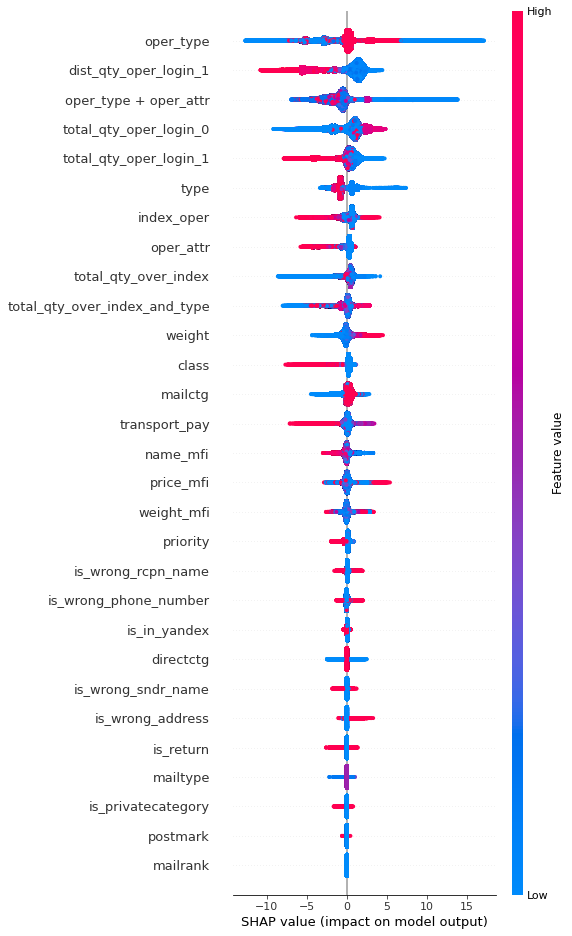

In [172]:
shap_test = shap.TreeExplainer(best_clf).shap_values(X)
shap.summary_plot(shap_test, X, max_display=29, auto_size_plot=True)

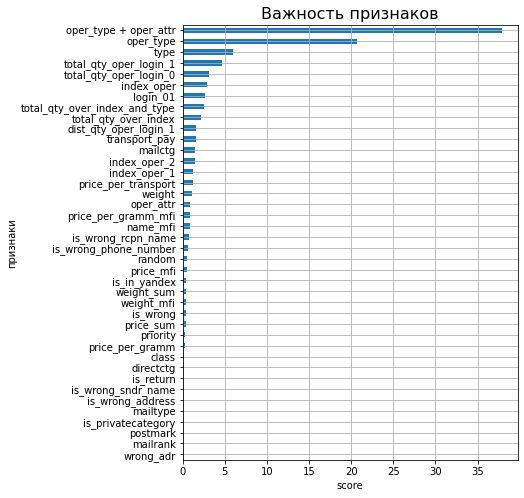

In [62]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': best_clf_cat.feature_importances_}, 
                            index=X.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(6,8), legend=False);
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

In [31]:
efectiv_score.sort_values(by='score')

,score
wrong_adr,0
is_privatecategory,0
is_in_yandex,0
is_return,0
postmark,0
mailrank,0
is_wrong_sndr_name,3
mailtype,16
oper_type + oper_attr + type,18
class,31


In [32]:
no_efect_features = [_ for _ in efectiv_score[efectiv_score['score'] < 10].index]
no_efect_features

['wrong_adr',
 'is_privatecategory',
 'is_in_yandex',
 'is_return',
 'postmark',
 'mailrank',
 'is_wrong_sndr_name']

In [33]:
no_efect_features = no_efect_features + ['random']

In [55]:
X = X.drop('zero',1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [56]:
X.shape

(7538820, 44)